# The Monte Carlo method

The Monte Carlo method is a computational technique that uses **<font color='teal'>`random sampling`</font>** to estimate complex mathematical outcomes or solve problems that might be **<font color='teal'>`deterministic`</font>** in nature.

## Monte Carlo integration

Let us consider the example of computing of an integral of a function. This is a deterministic problem, but we will solve it using random sampling.

**Problem to solve:** find value of the integral

$$\int_a^b f(x)dx. $$

Monte Carlo integration estimates this integral by finding the fraction of random points that fall below $f(x)$.

In the **Bayesian inference** context, we are usually interested in estimating expectations (which are themselves point estimates):

$$ E[h(x)] = \int h(x)f(x)dx,$$

which can be done with

$$ \bar{h}_n = \frac{1}{n} \sum_i^n h(x_i),$$
where $x_i ∼ f$ is a draw from the density $f$.

**Exercise:** _Do you see how this is **sampling** to figure out a property?_

The convergence of Monte Carlo integration is $\mathcal{O}(n^{1/2})$ and is independent of the dimensionality. Hence, Monte Carlo integration **generally** beats numerical intergration for moderate- and high-dimensional integration since numerical integration (quadrature) converges as $0(n^d)$!

### Monte Carlo integration - Example

Estimate the integral $\int_0^1 e^x dx$ using Monte Carlo integration.

In [24]:
import random
import math
import numpy as np
import jax.numpy as jnp
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.patches as patches

1.7182817
        10 1.630969
       100 1.467872
      1000 1.712517
     10000 1.703275
    100000 1.713088
   1000000 1.717307
  10000000 1.718232
 100000000 1.718354


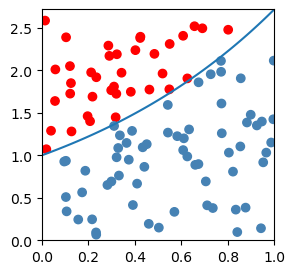

In [7]:
print(jnp.exp(1) - jnp.exp(0))

plt.figure(figsize=(3, 3))

x = jnp.linspace(0, 1, 100)
plt.plot(x, jnp.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= jnp.e

cols = ['steelblue'] * 100
for i in range(100):
    if pts[i,1] > jnp.exp(pts[i,0]):     # acceptance / rejection step
        cols[i] = 'red'


plt.scatter(pts[:, 0], pts[:, 1], c = cols)
plt.xlim([0,1])
plt.ylim([0, jnp.e]);

# Monte Carlo approximation

for n in 10**np.array([1, 2, 3, 4, 5, 6, 7, 8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= jnp.e
    count = jnp.sum(pts[:, 1] < jnp.exp(pts[:, 0]))
    volume = jnp.e * 1 # volume of region
    sol = (volume * count)/n
    print('%10d %.6f' % (n, sol))

### The Monte Carlo method - computing $\pi$

We can also use Monte Carlo to estimate the value of π!

In [8]:
#@title The Monte Carlo method - computing π

def in_circle(x, y, r):
    # is point (x,y) within circle of radius r?

    return jnp.sqrt(x **2 + y**2) <= r**2

def approx_pi(r, n):

    xs, ys, cols = [], [], []

    count = 0

    for i in range(n):
        x = np.random.uniform(0,r,1)
        y = np.random.uniform(0,r,1)
        xs.append(x)
        ys.append(y)

        if in_circle(x, y, r):
            count += 1
            cols.append("red")
        else:
            cols.append("steelblue")

    pi_appr = round(4 * count/n, 3)

    plt.figure(figsize=(2, 2))
    plt.scatter(xs, ys, c = cols, s=2)
    plt.title("pi (approximately) = " + str(pi_appr))
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return pi_appr

**Group task Β14.**

Using the functions above, iterate $n$ through vaules $5*10^1, 5*10^2, 5*10^3$ and run the function approximating $\pi$. How does the result change?

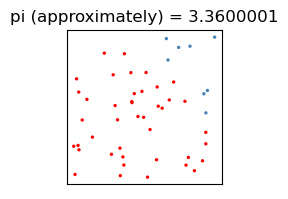

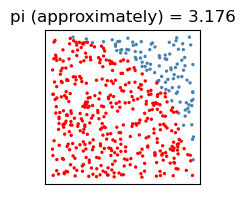

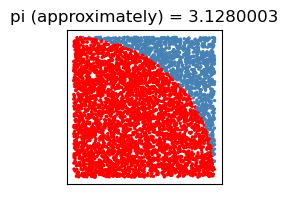

In [9]:
r = 1

for n in 5*10**jnp.array([1,2,3]):
    approx_pi(r, n)

## Markov Chain Monte Carlo (MCMC) 

We want to estimate the posterior distribution, but this is often intractable.

MCMC is a computational technique used to approximate complex probability distributions by generating a **<font color='teal'>`sequence of (correlated) samples`</font>**, where each sample is obtained by iteratively transitioning through a Markov chain with carefully designed transition probabilities.

### How does MCMC work (very rough overview)?

- Draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain).
- Under certain conditions, the Markov chain will have a unique stationary distribution.

- We set up an acceptance criteria for each draw based on comparing successive states with respect to a target distribution that enusre that the stationary distribution is the posterior distribution we are searching for.

- There is no need to evaluate the potentially intractable marginal likelihood.

- After sufficient number of iterations, the Markov chain of accepted draws will converge to the staionary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution.

The next optional section demonstrates an example of **<font color='teal'>`Matrolopolis-Hastings`</font>** algorithm - this is an example of MCMC.

## Metropolis-Hastings random walk algorithm

- Start with an initial guess for $\theta$

- Chose a new proposed value as $\theta_p = \theta + \delta_\theta, \delta_\theta \sim N(0, \sigma).$
   
  Here we have chosen the proposal distribution to be $N(0, \sigma).$
  
- If $g$ is the posterior probability, calculate the ratio $\rho = \frac{g(\theta_p \mid X)}{g(\theta \mid X)}$

- (adjust for symmetry of the proposal distribution)


- If $\rho \ge 1,$ accept $\theta = \theta_p;$ if $\rho < 1,$ accept  $\theta = \theta_p$ with probability $p,$ otherwise keep $\theta = \theta.$ (This step is done with the help of the standard Uniform distribution)

Portion of accepted steps = 0.1801


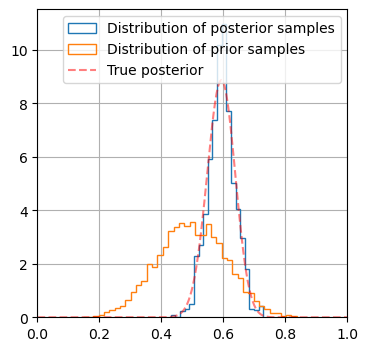

In [13]:
#@title Metropolis-Hastings

def target(likelihood, prior, n, h, theta):
    """
    define target distribution
    """
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(n, theta).pmf(h)*prior.pdf(theta)


# number of experiments
n = 100

# number of successes
h = 61

# hyperparameters for the prior
a = 10
b = 10
likelihood = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

# initilisation
naccept = 0
theta = 0.1

# set the number of MCMC iterations
niters = 10000

# run MH
samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta

# analyse MH output
nmcmc = len(samples)//2
print("Portion of accepted steps = " + str(naccept/niters))

post = stats.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(4, 4))
plt.hist(samples[nmcmc:], 20, histtype='step', linewidth=1, label='Distribution of posterior samples', density =True);
plt.hist(prior.rvs(nmcmc), 40, histtype='step',  linewidth=1, label='Distribution of prior samples', density=True);
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.grid(0.3)
plt.legend(loc='best');

We run the chain for $N$ iterations and discard the first $B$ samples. This is called **<font color='purple'>`burn-in`</font>** (or "warm-up").

We can run several parallel versions of the algorithm. Each of them is called a **<font color='green'>`chain`</font>**.

Neigbouring samples will contain similar information. We might want to save only every second, or fifth, or tenth. This is called **<font color='orange'>`thinning`</font>**.

## Convergence diagnostics

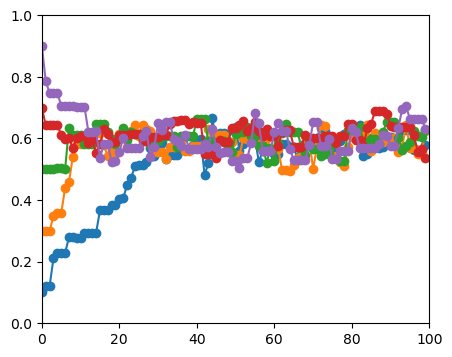

In [14]:
#@title Convergence diagnostics

def mh_coin(niters, n, h, theta, likelihood, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)

    return samples

n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100

chains = [mh_coin(niters, n, h, theta, likelihood, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

# compare multiple chains

plt.figure(figsize=(5, 4))

for chain in chains:
    plt.plot(chain, '-o')

plt.xlim([0, niters])
plt.ylim([0, 1]);

Was it very painful to write a sampler by hand?

If not, bare in mind that we only wrote the simplest one possible! Sampling algorithms can get very complicated. 🧠

## Buffon's needle problem

Here is another interesting example where random number generation can help us solve an analytical problem.

Buffon's Needle is a classic probability problem that involves randomly dropping a needle of a certain length onto a floor with parallel lines drawn at regular intervals. The goal is to estimate the probability that the needle will intersect one of the lines. The probability can be calculated using the following formula:

$$
P = \frac{2L}{\pi d}
$$

Where:

- $P$  is the estimated probability of the needle intersecting a line.
- $L$  is the length of the needle.
- $d$  is the distance between the lines on the floor

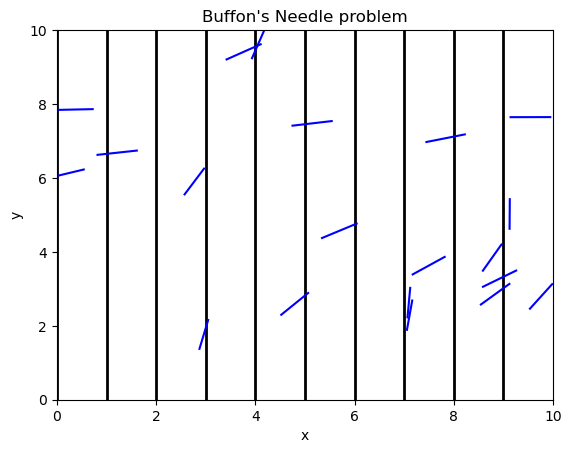

In [31]:
# Visualise Buffon's needle problem
num_lines = 10       # Number of parallel lines
line_spacing = 1.0  # Distance between lines
needle_length = 0.8 # Length of the needle
num_needles = 20   # Number of needles to drop

# Create a figure and axis for visualization
fig, ax = plt.subplots()

# Draw the parallel lines vertically
for i in range(num_lines):
    line_x = i * line_spacing
    ax.axvline(x=line_x, color='black', linewidth=2)

# Simulate dropping needles and visualize them
for _ in range(num_needles):
    # Randomly choose a midpoint and an angle for the needle
    mid_point_x = random.uniform(0, num_lines * line_spacing)
    mid_point_y = random.uniform(0, num_lines * line_spacing)
    angle = random.uniform(0, math.pi / 2)

    # Calculate the endpoints of the needle
    x0 = mid_point_x - (needle_length / 2) * math.cos(angle)
    x1 = mid_point_x + (needle_length / 2) * math.cos(angle)
    y0 = mid_point_y - (needle_length / 2) * math.sin(angle)
    y1 = mid_point_y + (needle_length / 2) * math.sin(angle)

    # Plot the needle as a line segment
    ax.plot([x0, x1], [y0, y1], color='blue')

# Set plot limits and labels
ax.set_xlim([0, num_lines * line_spacing])
ax.set_ylim([0, num_lines * line_spacing])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Buffon's Needle problem")

# Show the plot
plt.show()

Let's write Python code to simulate Buffon's Needle experiment and estimate the probability.

This code simulates the dropping of needles and calculates the estimated probability of the needle intersecting one of the lines. The more needles you drop, the closer the estimated probability will be to the actual value of $\frac{2L}{\pi d}$.


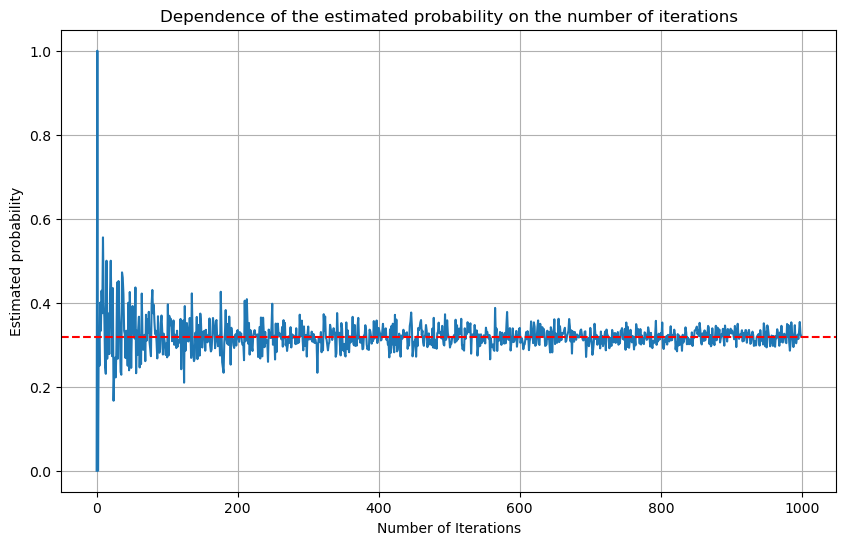

In [21]:
def buffon_needle_simulation(num_needles, needle_length, line_spacing):
    intersected = 0

    for _ in range(num_needles):
        # Generate a random angle between 0 and 180 degrees (in radians)
        angle = random.uniform(0, math.pi / 2)

        # Generate a random position for the midpoint of the needle
        mid_point = random.uniform(0, line_spacing / 2)

        # Check if the needle intersects a line
        if mid_point <= (needle_length / 2) * math.sin(angle):
            intersected += 1

    # Estimate the probability
    if intersected == 0:
        estimated_probability = 0
    else:
        estimated_probability = intersected / num_needles

    return estimated_probability

def compute_true_value(needle_length, line_spacing):
    true_value = (2 * needle_length) / (math.pi * line_spacing)
    return true_value


# Input parameters
needle_length = 1.0      # Length of the needle
line_spacing = 2.0       # Distance between the lines
max_num_needles = 1000   # maximum number of needles to drop 

estimates = []

for num_needles in range(max_num_needles):
    estimated_probability = buffon_needle_simulation(num_needles, needle_length, line_spacing)
    estimates.append(estimated_probability)

# Compute the true value
true_value = compute_true_value(needle_length, line_spacing)


# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(range(max_num_needles), estimates)
plt.xlabel('Number of Iterations')
plt.ylabel('Estimated probability')
plt.axhline(y=true_value, color='red', linestyle='--', label='True Value')
plt.title('Dependence of the estimated probability on the number of iterations')
plt.grid(True)

# Show the plot
plt.show()


You can read more on the analytical solution of the version of this problem over a grid [here](https://mathworld.wolfram.com/Buffon-LaplaceNeedleProblem.html).